### ITSM Ticket automation using RNN


1. NLP using LSTM to the Description of the problem
2. Run RNN for the attributes

In [74]:
import keras 
import numpy as np
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [75]:
data = pd.read_csv('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/incident 05-09-19.csv', encoding = "cp1252")

### Actions:
1. Balance the data sample.
2. Description has null values; we will use short description in case of missing description, and filter any record where no description nor short description is provided
3. Removing any occurence where 

In [76]:
# replacing na values in description with the Short Description 
data["Description"].fillna(data["Short_Description"], inplace = True) 
data = data.dropna(subset = ['Resolved_by_group'])


In [77]:
#Cleaning Description using short description for observations recorded by Netcool Alerting tool
data['Description'] = data.apply(
    lambda row: row.Short_Description if 'Netcool Fields:' in row.Description else row.Description ,  axis = 1)


In [78]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Assignment_group,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved
0,INC000017612819,SIMS blank page when open with IE\r\n??IE ??S...,SIMS blank page,YUTONG ZHOU (152062324),Priority 4,Software,Website,Low,Limited,SIMS LATAM,...,GLOBAL SERVICE DESK,Closed Complete,Change Implementation,NaN,GLOBAL SERVICE DESK,JING HUANG (645010504),KB000010025934,LATAM,2017-11-12 21:03,2017-11-12 21:03
1,INC000020585404,"For dim_slt_id=203, dim_task_id=1658 exited wi...",TASK_STATUS - SLT ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Job Failure,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Closed Complete,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010080602,NaN,2019-08-04 3:30,2019-08-06 6:39
2,INC000020692831,"For DIM_SLT_ID=203, following task(s) violated...",TASK_END_DELAY violated for DIM_SLT_ID 203,AGGRIFY SLT AUTOMATION (702303384),Priority 4,Application,Poor performance,Low,Limited,MENTOR BI SALES ANALYTICS,...,DATA AND ANALYTICS RR LTI,Draft,Job Failure,NA US NJ RARITAN,DATA AND ANALYTICS RR LTI,DILIP KHANDAI (643026421),KB000010081617,NaN,2019-08-24 2:15,2019-08-28 4:55
3,INC000017000450,??????,Software - J&J business applications: Unavaila...,ZHIYU ZHANG (85434123),Priority 4,Software,Website,Low,Localized,JJMC IPOWER -- PROF ED HCP MASTER DATABASE,...,AS MEDICAL APP CHINA L2,Closed Complete,User Access / Permission,ASPAC CN SHANGHAI,AS MEDICAL APP CHINA L2,WEI WANG (702020246),NaN,ASPAC,2017-06-27 3:26,2017-06-29 2:04
4,INC000017291067,> DS huddle Login issue,> DS huddle Login issue,SEAN FOLEY (702113126),Priority 4,Software,Desktop Software,Low,Localized,DS MOBILE,...,GLOBAL SERVICE DESK,Closed Complete,User Access / Permission,NA US NJ RARITAN,GLOBAL SERVICE DESK,ABEGAIL COMON (645001723),KB000010027981,NaN,2017-08-31 10:34,2017-08-31 14:36


In [79]:
data = data.groupby('Resolved_by_group').filter(lambda x : len(x)>1000)

In [80]:
data.Resolved_by_group.value_counts()

DATA AND ANALYTICS RR LTI    8475
CBT RR COG                   7659
DATA AND ANALYTICS RR TCS    7135
GLOBAL SERVICE DESK          4994
DATA AND ANALYTICS RR COG    1749
ASPAC CONSUMER DNA L2        1615
C3I LEVEL I                  1379
GLOBAL ANALYTICS CONSUMER    1341
GLOBAL ANALYTICS PHARMA      1161
DIG ECOM SOC COL RR COG      1125
Name: Resolved_by_group, dtype: int64

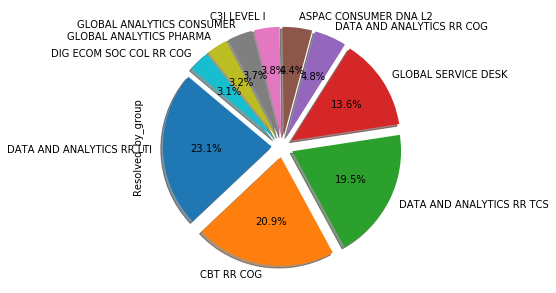

In [83]:
chart=data.Resolved_by_group.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Resolved_by_group', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [84]:
from sklearn.utils import resample

df_1 = data[data.Resolved_by_group=='DATA AND ANALYTICS RR LTI']
df_2 = data[data.Resolved_by_group=='CBT RR COG']
df_3 = data[data.Resolved_by_group=='DATA AND ANALYTICS RR TCS']
df_4 = data[data.Resolved_by_group=='GLOBAL SERVICE DESK']
df_5 = data[data.Resolved_by_group=='DATA AND ANALYTICS RR COG']
df_6 = data[data.Resolved_by_group=='ASPAC CONSUMER DNA L2']
df_7 = data[data.Resolved_by_group=='C3I LEVEL I']
df_8 = data[data.Resolved_by_group=='GLOBAL ANALYTICS CONSUMER']
df_9 = data[data.Resolved_by_group=='GLOBAL ANALYTICS PHARMA']
df_10 = data[data.Resolved_by_group=='DIG ECOM SOC COL RR COG']


df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_3_upsampled = resample(df_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_4_upsampled = resample(df_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_5_upsampled = resample(df_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_6_upsampled = resample(df_6, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_7_upsampled = resample(df_7, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_8_upsampled = resample(df_8, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_9_upsampled = resample(df_9, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

df_10_upsampled = resample(df_10, 
                                 replace=True,     # sample with replacement
                                 n_samples=1125,    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled, df_5_upsampled, df_6_upsampled, df_7_upsampled, df_8_upsampled, df_9_upsampled, df_10_upsampled])

In [85]:
data.Resolved_by_group.value_counts()

DATA AND ANALYTICS RR COG    1125
DATA AND ANALYTICS RR TCS    1125
CBT RR COG                   1125
ASPAC CONSUMER DNA L2        1125
DIG ECOM SOC COL RR COG      1125
GLOBAL SERVICE DESK          1125
GLOBAL ANALYTICS PHARMA      1125
DATA AND ANALYTICS RR LTI    1125
GLOBAL ANALYTICS CONSUMER    1125
C3I LEVEL I                  1125
Name: Resolved_by_group, dtype: int64

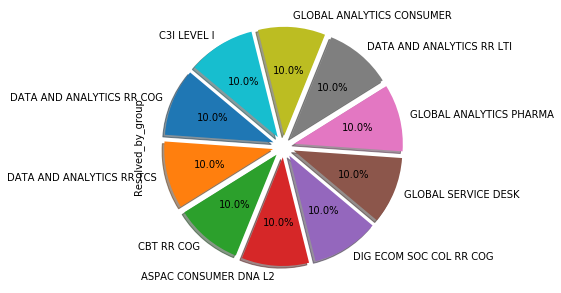

In [86]:
chart=data.Resolved_by_group.value_counts()
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)
plot = chart.plot.pie(y='Resolved_by_group', figsize=(5, 5), explode=explode, subplots=True, autopct='%1.1f%%', shadow=True, startangle=140)


In [87]:
from sklearn.utils import resample

df_1 = data[data.Sub_Category=='Availability']
df_2 = data[data.Sub_Category=='Enterprise software']
df_3 = data[data.Sub_Category=='Job Failure']
df_4 = data[data.Sub_Category=='Poor performance']
df_5 = data[data.Sub_Category=='Data Issue']
df_6 = data[data.Sub_Category=='Website']
df_7 = data[data.Sub_Category=='Desktop Software']
 
df_1_upsampled = resample(df_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_2_upsampled = resample(df_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_3_upsampled = resample(df_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_4_upsampled = resample(df_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_5_upsampled = resample(df_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_6_upsampled = resample(df_6, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results

df_7_upsampled = resample(df_7, 
                                 replace=True,     # sample with replacement
                                 n_samples=2203,    # to match majority class
                                 random_state=123) # reproducible results


# Combine majority class with upsampled minority class
data = pd.concat([df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled, df_5_upsampled, df_6_upsampled, df_7_upsampled])

In [88]:
data['target_grp'] = data.Resolved_by_group.astype('category').cat.codes


In [89]:
labels_grp = data.Resolved_by_group.astype('category').cat.categories


In [90]:
df = pd.DataFrame(labels_grp) 
df.to_csv ('/Users/jairomelo/Desktop/ML/YORK/ML1030/Capstone Project/labels_grp.csv')


In [91]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,State.1,Resolution_category,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_grp
51821,INC000019954346,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Limited,ASP EDW-COGNOS,...,Closed Complete,Job Failure,NaN,DATA AND ANALYTICS RR TCS,NITHILA BALASUBRAMANIAN (643023404),KB000010052718,NaN,2019-03-27 6:32,2019-03-28 2:16,5
44998,INC000020046230,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 3,Monitoring,Availability,Medium,Large,GS PERFORMANCE METRICS - PROD,...,Closed Complete,Interface or Middleware,NaN,CBT RR COG,RAVEENDRABABU PODAPATI (643021964),KB000010065917,GLOBAL,2019-04-14 20:30,2019-04-16 7:48,2
25845,INC000020709758,Control-M: 34_APP - Event: JOB NOT OK App: ASP...,Control-M: 34_APP - Event: JOB NOT OK App: ASP...,NETCOOL AGENT (702116225),Priority 3,Monitoring,Availability,Medium,Large,ASPAC DNA PLATFORM,...,Draft,Job Failure,NaN,DATA AND ANALYTICS RR COG,SRINIVASA RAO AMBATI (643027241),NaN,ASPAC,2019-08-27 20:03,2019-08-29 8:51,3
41508,INC000019742064,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 3,Monitoring,Availability,Medium,Large,BIW-COGNOS-PROD (CONCA),...,Closed Complete,Job Failure,NaN,GLOBAL ANALYTICS CONSUMER,ASHISH GUPTA (643016777),NaN,NaN,2019-02-10 11:44,2019-02-11 3:53,7
6162,INC000020373401,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Limited,GFS - FP&A - FINANCIAL REPORTING,...,Closed Complete,Data Issue,NaN,CBT RR COG,VIJAYASEKHAR REDDY (643025460),KB000010046825,GLOBAL,2019-06-21 5:19,2019-06-21 12:06,2


In [92]:
data['num_words'] = data['Description'].apply(lambda x : len(x.split()))

In [93]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,10,30,60,130, np.inf], labels=['0-10', '10-30', '30-60','60-130' ,'>130'])


In [94]:
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [95]:
word_distribution.head()

,bins,counts
0,0-10,4645
1,10-30,5727
2,30-60,3265
3,60-130,1439
4,>130,345


Text(0.5, 1.0, 'Word distribution per bin')

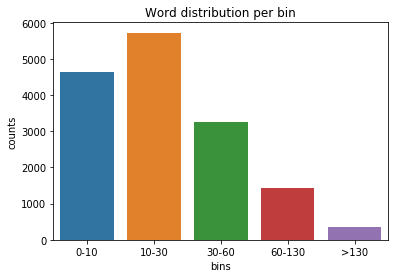

In [96]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [97]:
data.head()

,Number,Description,Short_Description,Caller,Priority,Category,Sub_Category,Urgency,Impact,Configuration_item,...,Site,Resolved_by_group,Resolved_by,KCS_solution,CI_regions,Created,Resolved,target_grp,num_words,bins
51821,INC000019954346,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Limited,ASP EDW-COGNOS,...,NaN,DATA AND ANALYTICS RR TCS,NITHILA BALASUBRAMANIAN (643023404),KB000010052718,NaN,2019-03-27 6:32,2019-03-28 2:16,5,17,10-30
44998,INC000020046230,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 3,Monitoring,Availability,Medium,Large,GS PERFORMANCE METRICS - PROD,...,NaN,CBT RR COG,RAVEENDRABABU PODAPATI (643021964),KB000010065917,GLOBAL,2019-04-14 20:30,2019-04-16 7:48,2,17,10-30
25845,INC000020709758,Control-M: 34_APP - Event: JOB NOT OK App: ASP...,Control-M: 34_APP - Event: JOB NOT OK App: ASP...,NETCOOL AGENT (702116225),Priority 3,Monitoring,Availability,Medium,Large,ASPAC DNA PLATFORM,...,NaN,DATA AND ANALYTICS RR COG,SRINIVASA RAO AMBATI (643027241),NaN,ASPAC,2019-08-27 20:03,2019-08-29 8:51,3,15,10-30
41508,INC000019742064,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 3,Monitoring,Availability,Medium,Large,BIW-COGNOS-PROD (CONCA),...,NaN,GLOBAL ANALYTICS CONSUMER,ASHISH GUPTA (643016777),NaN,NaN,2019-02-10 11:44,2019-02-11 3:53,7,15,10-30
6162,INC000020373401,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...,NETCOOL AGENT (702116225),Priority 4,Monitoring,Availability,Low,Limited,GFS - FP&A - FINANCIAL REPORTING,...,NaN,CBT RR COG,VIJAYASEKHAR REDDY (643025460),KB000010046825,GLOBAL,2019-06-21 5:19,2019-06-21 12:06,2,18,10-30


In [98]:
num_class_grp = len(np.unique(data.Resolved_by_group.values))
y_grp = data['target_grp'].values


## Topic Modelling

In [99]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np
import pandas as pd
import re
import warnings
from sklearn.metrics import confusion_matrix
#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
#from mpl_toolkits.basemap import Basemap
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

In [100]:
data['Description'] = data['Description'].astype(str)

In [101]:
type(data['Description'])

pandas.core.series.Series

In [102]:
data_description = data.Description.values

In [103]:
type(data_description)

numpy.ndarray

In [104]:
#cv = # Initialize a CountVectorizer object: count_vectorizer
count_vec = CountVectorizer(stop_words="english", analyzer='word', 
                            ngram_range=(1, 1), max_df=1, min_df=1, max_features=None)

# convert text data into term-frequency matrix
data_description = count_vec.fit_transform(data_description)




tfidf_transformer = TfidfTransformer()

# convert term-frequency matrix into tf-idf
tfidf_matrix = tfidf_transformer.fit_transform(data_description)

# create dictionary to find a tfidf word each word
word2tfidf = dict(zip(count_vec.get_feature_names(), tfidf_transformer.idf_))

for word, score in word2tfidf.items():
    print(word, score)

000000000520001500 9.95040315983296
000000000520016500 9.95040315983296
000000000520016600 9.95040315983296
000000000520016700 9.95040315983296
000000000523062000 9.95040315983296
000000000523062500 9.95040315983296
000000000523069500 9.95040315983296
00004964 9.95040315983296
00016274 9.95040315983296
00016509 9.95040315983296
0001_4c763009b0174bee82539db6b5a55f7d_0vendor_text_bw_bpc330_emea 9.95040315983296
00022796180018 9.95040315983296
00022796180124 9.95040315983296
00022796180148 9.95040315983296
00022796180155 9.95040315983296
00022796180315 9.95040315983296
00022796180520 9.95040315983296
00022796180612 9.95040315983296
00022796180629 9.95040315983296
00022796180650 9.95040315983296
00022796180728 9.95040315983296
00022796183019 9.95040315983296
00022796183026 9.95040315983296
00022796901200 9.95040315983296
00022796910936 9.95040315983296
00022796910943 9.95040315983296
00022796914316 9.95040315983296
00022796914323 9.95040315983296
00022796916112 9.95040315983296
00022796916

frederic 9.95040315983296
freeze 9.95040315983296
frequent 9.95040315983296
fri 9.95040315983296
frshbrst 9.95040315983296
fsilva66 9.95040315983296
fso 9.95040315983296
ftz 9.95040315983296
funcionario 9.95040315983296
gastrocentral 9.95040315983296
gbi 9.95040315983296
gbu 9.95040315983296
gc 9.95040315983296
gcso_bi_read 9.95040315983296
gcso_dev_read 9.95040315983296
gel 9.95040315983296
gender 9.95040315983296
generating 9.95040315983296
generic 9.95040315983296
genesys 9.95040315983296
getimagesbydate 9.95040315983296
gfdw_jpjde_lnd_cust_mst_hd 9.95040315983296
gfdw_jpsynthes_lnd_copa_mst_hd_fw7 9.95040315983296
gfk 9.95040315983296
gfk_nielsen_qa 9.95040315983296
gfs_functional_area_code 9.95040315983296
gina 9.95040315983296
gko 9.95040315983296
gl_account_cd 9.95040315983296
glovis 9.95040315983296
gmap 9.95040315983296
gmt 9.95040315983296
googled 9.95040315983296
grain 9.95040315983296
greece 9.95040315983296
grofers 9.95040315983296
grouping 9.95040315983296
grp 9.950403159

In [105]:
term_frequency = count_vec.vocabulary_
type(term_frequency)

dict

In [106]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
feature_names = np.array(count_vec.get_feature_names())
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:10]]))
print("\nFeatures with highest idf:\n{}".format(
       feature_names[sorted_by_idf[-10:]]))

Features with lowest idf:
['000000000520001500' 'j_validation_sellout_excel_files'
 'j_vacuum_and_analyze' 'j_tw_ims_distributor_standard_sell_out_wrapper'
 'j_step1_validation' 'j_sfdc_to_esp_lnd_data_ingestion_full'
 'j_sfdc_mbox_to_esp_lnd_data_ingestion'
 'j_sfdc_esp_stg_to_wrk_case_csat_dataload_step1'
 'j_sfdc_esp_stg_to_core_teamtier_load'
 'j_sfdc_esp_stg_to_core_task_dataload']

Features with highest idf:
['banned' 'baltics' 'backurl' 'b42' 'awsclientexception' 'avenue'
 'aveeeno' 'avaialable' 'bate' 'zugriff']


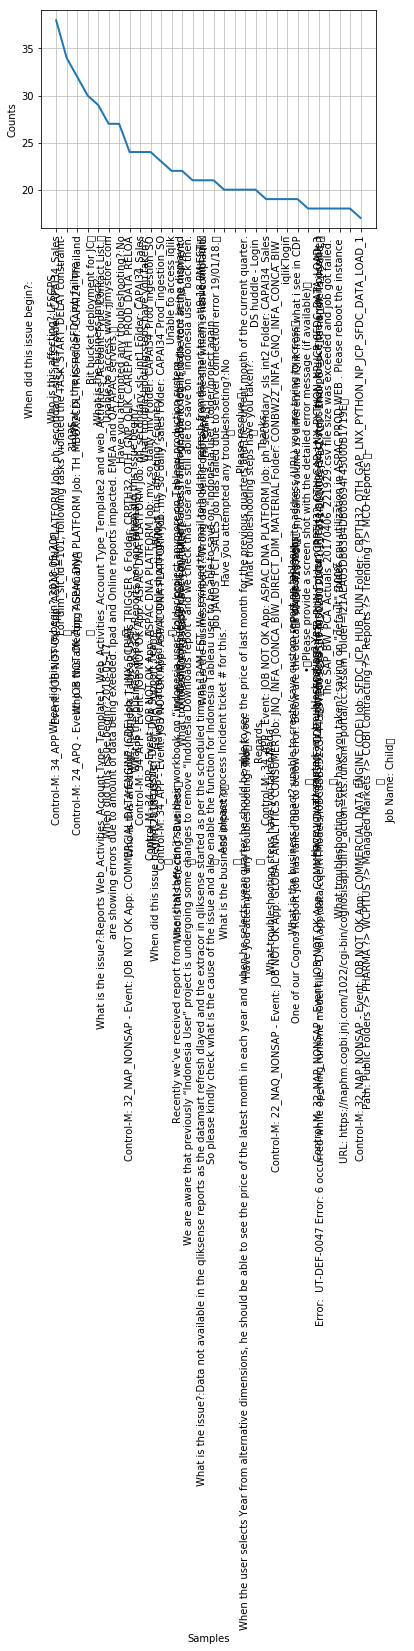

In [107]:
count = nltk.FreqDist(data.Description.values)
count.plot(30)

In [108]:
final_doc = data['Description']
all_documents = tuple(final_doc)

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(all_documents)
print (tfidf_matrix.shape)
print(tfidf_matrix)

(15421, 12013)
  (0, 4461)	0.1533639316291023
  (0, 1662)	0.18673921567855473
  (0, 5700)	0.15448751503619518
  (0, 7419)	0.25447052304356443
  (0, 8654)	0.11582981751600036
  (0, 8758)	0.15482922167304344
  (0, 3405)	0.1489471228470246
  (0, 4692)	0.16036050046551975
  (0, 3319)	0.15582099481629755
  (0, 3312)	0.2555649383173978
  (0, 10025)	0.3199325067722576
  (0, 11021)	0.34855263504706924
  (0, 4924)	0.46032318549323725
  (0, 5985)	0.1542835289357758
  (0, 673)	0.4675005342940261
  (1, 4461)	0.1535632799040538
  (1, 1662)	0.1869819464178875
  (1, 5700)	0.1546883237876198
  (1, 7419)	0.25480129351388214
  (1, 8654)	0.11598037752097991
  (1, 8758)	0.15503047458775904
  (1, 3405)	0.14914072998582925
  (1, 5985)	0.1544840725383039
  (1, 6362)	0.322360569415693
  (1, 9061)	0.29044179710634627
  :	:
  (15419, 8437)	0.16645573760043075
  (15419, 11108)	0.18171571114208154
  (15419, 10596)	0.15522902030585478
  (15419, 10011)	0.2018994053004904
  (15419, 9729)	0.19744782852200404
  (15419

In [110]:
reindexed_data= data["Description"]

data_text = data[['Description']]
data_text['index'] = data_text.index
documents=data_text


print(len(documents))
print(documents[:5])

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

15421
                                             Description  index
51821  Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...  51821
44998  Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...  44998
25845  Control-M: 34_APP - Event: JOB NOT OK App: ASP...  25845
41508  Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...  41508
6162   Control-M: 32_NAP_NONSAP - Event: JOB NOT OK A...   6162


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [114]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmer.stem('identified')


doc_sample = documents[documents['index'] == 15].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


processed_docs = documents['Description'].map(preprocess)
processed_docs[:5]

original document: 
['ds', 'huddle', 'unable', 'to', 'access']


 tokenized and lemmatized document: 
['huddl', 'unabl', 'access']


51821         [control, event, data, analyt, folder, aspw]
44998    [control, event, perform, metric, prod, folder...
25845     [control, event, aspac, platform, folder, capai]
41508    [control, event, cogno, prod, conca, infa, fol...
6162     [control, event, fpna, financi, report, folder...
Name: Description, dtype: object

## LDA with Gensim:

### Create a dictionary from the data, then convert to bag-of-words corpus and save the dictionary and corpus for future use.

In [115]:
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 analyt
1 aspw
2 control
3 data
4 event
5 folder
6 gspmp
7 metric
8 perform
9 prod
10 aspac


In [116]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[123]

[(9, 1)]

In [117]:
#Preview Bag Of Words for our sample preprocessed document.
bow_doc_123 = bow_corpus[123]
for i in range(len(bow_doc_123)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_123[i][0], 
                                               dictionary[bow_doc_123[i][0]], 
bow_doc_123[i][1]))

Word 9 ("prod") appears 1 time.


In [118]:
#TF-IDF
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.43702929356880993),
 (1, 0.7831949508932834),
 (2, 0.21651556143486467),
 (3, 0.23182363206561216),
 (4, 0.2190550903320608),
 (5, 0.2168057843556762)]


### Finding out 5 topics using LDA

In [119]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=5, id2word=dictionary, passes=2, workers=2)

In [120]:
# Print the results
import pickle

# Here we can assign topic names to each topic list, you can specify the number of words you want to have shown (e.g num_words = 5)
result = lda_model.print_topics(num_topics=5, num_words=5)
print(result)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

[(0, '0.032*"data" + 0.027*"product" + 0.023*"issu" + 0.018*"report" + 0.017*"team"'), (1, '0.052*"report" + 0.049*"folder" + 0.049*"event" + 0.048*"control" + 0.029*"aspac"'), (2, '0.115*"dim_task_id" + 0.111*"task_nam" + 0.100*"start_tim" + 0.100*"end_tim" + 0.057*"dim_slt_id"'), (3, '0.052*"access" + 0.039*"user" + 0.038*"iqlik" + 0.023*"unabl" + 0.020*"http"'), (4, '0.102*"issu" + 0.093*"troubleshoot" + 0.053*"busi" + 0.048*"impact" + 0.047*"take"')]
Topic: 0 
Words: 0.032*"data" + 0.027*"product" + 0.023*"issu" + 0.018*"report" + 0.017*"team" + 0.015*"troubleshoot" + 0.014*"file" + 0.013*"check" + 0.013*"user" + 0.012*"tableau"
Topic: 1 
Words: 0.052*"report" + 0.049*"folder" + 0.049*"event" + 0.048*"control" + 0.029*"aspac" + 0.021*"platform" + 0.019*"fpapr" + 0.018*"financi" + 0.018*"fpna" + 0.018*"capai"
Topic: 2 
Words: 0.115*"dim_task_id" + 0.111*"task_nam" + 0.100*"start_tim" + 0.100*"end_tim" + 0.057*"dim_slt_id" + 0.056*"follow" + 0.055*"task" + 0.054*"violat" + 0.053*"con

In [121]:
# put these in a file and name the topics
with open("lda_topics_result.txt", "w") as f:
    for s in result:
        f.write(str(s) +"\n")

### pyLDAvis help to interpret the topics in a topic model that has been fit to a corpus of text data

In [122]:
# Visualize
import pyLDAvis.gensim

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus,dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

In [123]:
from collections import OrderedDict

data_lda = {i: OrderedDict(lda_model.show_topic(i,25)) for i in range(5)}

In [124]:
import pandas as pd

df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(87, 5)
(5, 87)


In [125]:
df_lda

,access,affect,applic,aspac,attach,attempt,begin,busi,capai,cde_bi,...,task_end_delay,task_nam,task_statu,team,thank,troubleshoot,unabl,unlock,user,violat
0,0.000000,0.007764,0.000000,0.000000,0.007699,0.000000,0.000000,0.011052,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.017491,0.008424,0.014503,0.000000,0.000000,0.012774,0.000000
1,0.007063,0.000000,0.000000,0.028861,0.000000,0.000000,0.000000,0.008222,0.01754,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008256,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.004947,...,0.024494,0.110864,0.006615,0.004661,0.000000,0.000000,0.000000,0.005053,0.000000,0.053848
3,0.052014,0.000000,0.009471,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.008991,0.000000,0.000000,0.000000,0.000000,0.023147,0.000000,0.038770,0.000000
4,0.000000,0.047340,0.000000,0.000000,0.000000,0.046615,0.046574,0.053208,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.006771,0.000000,0.092654,0.000000,0.000000,0.016585,0.000000


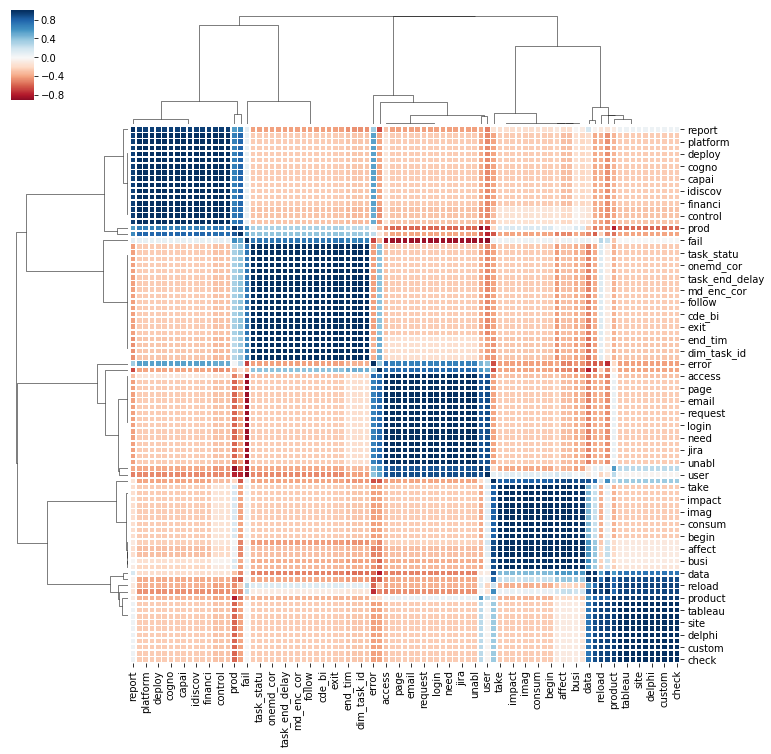

In [126]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [127]:
MAX_LENGTH = 500
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.Description.values)
post_seq = tokenizer.texts_to_sequences(data.Description.values)
post_seq_padded = pad_sequences(post_seq, maxlen=MAX_LENGTH)

In [128]:
def data_set_split (y):
    X_train, X_test, y_train, y_test = train_test_split(post_seq_padded, y, test_size=0.05,random_state=42)
    return X_train, X_test, y_train, y_test

In [129]:

vocab_size = len(tokenizer.word_index) + 1

## Deep Learning Model Simple

In [130]:
from sklearn.externals import joblib

In [131]:
def model_training(num_class, model_file):    
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                            128,
                            input_length=MAX_LENGTH)(inputs)
    x = Flatten()(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model = Model(inputs=[inputs], outputs=predictions)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
    model.summary()
    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model.fit([X_train], batch_size=124, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
          shuffle=True, epochs=10, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    
    return model

### Training Model to predict Support Group who might be able to resolved the ticket

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 128)          1524480   
_________________________________________________________________
flatten_2 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 3,572,842
Trainable params: 3,572,842
Non-trainable params: 0
_________________________________________________________________
Train on 10986 samples, validate on 3663 samples
Epoch 1/10
10986/10986 [==============================] - 7s 625us/step - loss: 1.8

['model-simple_grp.pkl']

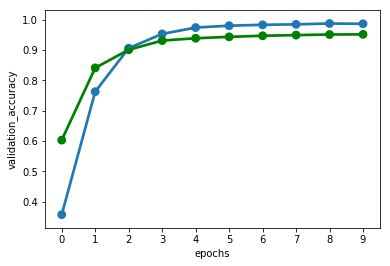

In [132]:
X_train, X_test, y_train, y_test = data_set_split(y_grp)

model_file = 'weights-simple_grp.hdf5'
model = model_training(num_class_grp, model_file)
joblib.dump(model,'model-simple_grp.pkl')

### Training Model to preduct Priority of the ticket

In [133]:
predicted = model.predict(X_test)
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.9507772020725389

In [134]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

In [135]:
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools

In [136]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
#This should be adjusted to the Predictor
#encoder.fit(data.Resolution_category.values)
encoder.fit(data.Resolved_by_group.values)
text_labels = encoder.classes_ 


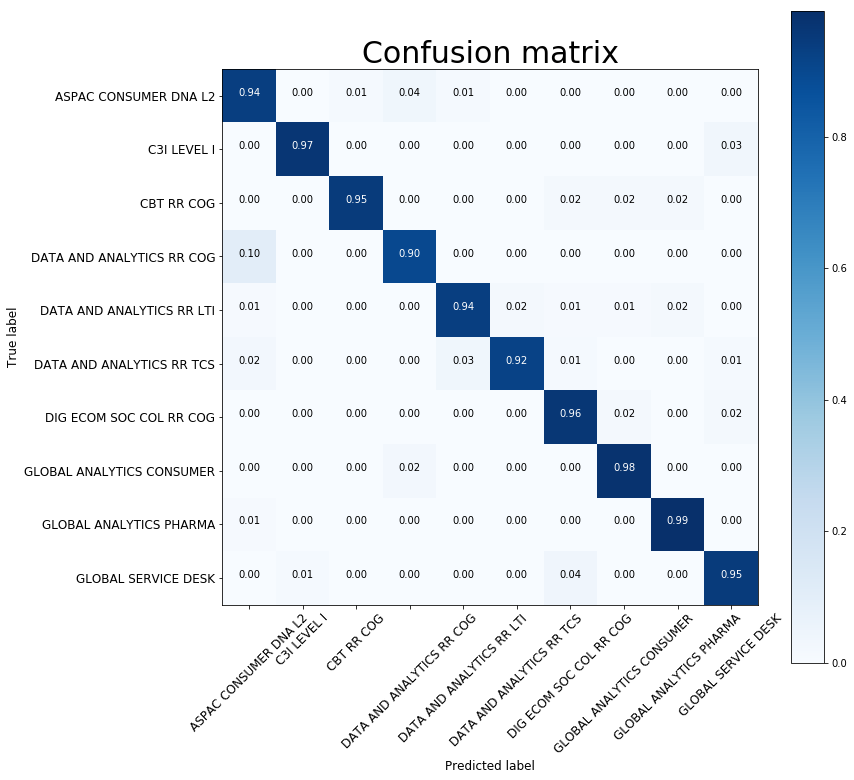

In [137]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

## RNN with LSTM Layer

In [139]:
def lstm_model_training(num_class, model_file): 
    inputs = Input(shape=(MAX_LENGTH, ))
    embedding_layer = Embedding(vocab_size,
                                128,
                                input_length=MAX_LENGTH)(inputs)
    x = LSTM(64)(embedding_layer)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(num_class, activation='softmax')(x)
    model_lstm = Model(inputs=[inputs], outputs=predictions)
    model_lstm.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['acc'])
    model_lstm.summary()

    checkpointer = ModelCheckpoint(model_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    history = model_lstm.fit([X_train], batch_size=64, y=to_categorical(y_train), verbose=1, validation_split=0.25, 
                             shuffle=True, epochs=20, callbacks=[checkpointer])
    
    df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['acc'], 'validation_accuracy': history.history['val_acc']})
    g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False)
    g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='green')
    return model_lstm


### Training Predictor for Support Group using LSTM RNN 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 500, 128)          1524480   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
Total params: 1,576,298
Trainable params: 1,576,298
Non-trainable params: 0
_________________________________________________________________
Train on 10986 samples, validate on 3663 samples
Epoch 1/20
10986/10986 [==============================] - 96s 9ms/step - loss: 1.46

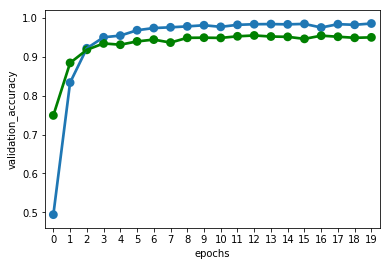

In [140]:
X_train, X_test, y_train, y_test = data_set_split(y_grp)
model_lstm = lstm_model_training(num_class_grp,"weights_grp.hdf5")
joblib.dump(model_lstm,'model_grp.pkl')
predicted = model_lstm.predict(X_test)


In [ ]:
predicted
predicted = np.argmax(predicted, axis=1)
accuracy_score(y_test, predicted)

0.9546632124352331

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))